# Performance Analysis of Hungarian Dance No. 5:

In [1]:
import os
import sys
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import ConnectionPatch
import librosa
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import scipy.spatial.distance as dist
import scipy.ndimage.filters
from scipy.io import wavfile
import libfmp.b
import libfmp.c1
import libfmp.c3
from numba import jit, njit
sys.path.append('..')

# Defining some functions:

In [2]:
def compute_score_chromagram(score, Fs_beat):
    """Compute chromagram from score representation"""
    score_beat_min = min(n[0] for n in score)
    score_beat_max = max(n[0] + n[1] for n in score)
    beat_res = 1.0 / Fs_beat
    t_beat = np.arange(score_beat_min, score_beat_max, beat_res)
    X_score = np.zeros((12, len(t_beat)))
    for start, duration, pitch, velocity, label in score:
        start_idx = int(round(start / beat_res))
        end_idx = int(round((start + duration) / beat_res))
        cur_chroma = int(round(pitch)) % 12
        X_score[cur_chroma, start_idx:end_idx] += velocity
    X_score = librosa.util.normalize(X_score, norm=2)
    return X_score, t_beat


def plot_measure(ax, measure_pos):
    """Plot measure positions"""
    y_min, y_max = ax.get_ylim()
    ax.vlines(measure_pos, y_min, y_max, color='r')
    for m in range(len(measure_pos)):
        ax.text(measure_pos[m], y_max, '%s' % (m + 1),
                color='r', backgroundcolor='mistyrose',
                verticalalignment='top', horizontalalignment='left')

        

def compute_strict_alignment_path(P):
    """Compute strict alignment path from a warping path"""
    # Initialize P_mod and enforce start boundary condition
    P_mod = np.zeros(P.shape)
    P_mod[0] = P[0]
    N, M = P[-1]
    # Go through all cells of P until reaching last row or column
    assert N > 1 and M > 1, 'Length of sequences must be longer than one.'
    i, j = 0, 0
    n1, m1 = P[i]
    while True:
        i += 1
        n2, m2 = P[i]
        if n2 == N or m2 == M:
            # If last row or column is reached, quit loop
            break
        if n2 > n1 and m2 > m1:
            # Strict monotonicity condition is fulfuilled
            j += 1
            P_mod[j] = n2, m2
            n1, m1 = n2, m2
    j += 1
    # Enforce end boundary condition
    P_mod[j] = P[-1]
    P_mod = P_mod[:j+1]
    return P_mod

def compute_strict_alignment_path_mask(P):
    """Compute strict alignment path from a warping path
    """
    P = np.array(P, copy=True)
    N, M = P[-1]
    # Get indices for strict monotonicity
    keep_mask = (P[1:, 0] > P[:-1, 0]) & (P[1:, 1] > P[:-1, 1])
    # Add first index to enforce start boundary condition
    keep_mask = np.concatenate(([True], keep_mask))
    # Remove all indices for of last row or column
    keep_mask[(P[:, 0] == N) | (P[:, 1] == M)] = False
    # Add last index to enforce end boundary condition
    keep_mask[-1] = True
    P_mod = P[keep_mask, :]
    return P_mod

def plot_tempo_curve(f_tempo, t_beat, ax=None, figsize=(8, 2), color='k', logscale=False,
                     xlabel='Time (beats)', ylabel='Temp (BPM)', xlim=None, ylim=None,
                     label='', measure_pos=[]):
    """Plot a tempo curve"""
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, 1, 1)
    ax.plot(t_beat, f_tempo, color=color, label=label)
    ax.set_title('Tempo curve')
    if xlim is None:
        xlim = [t_beat[0], t_beat[-1]]
    if ylim is None:
        ylim = [np.min(f_tempo) * 0.9, np.max(f_tempo) * 1.1]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, which='both')
    if logscale:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(ScalarFormatter())
        # ax.set_yticks([], minor=True)
        # yticks = np.arange(ylim[0], ylim[1]+1, 10)
        # ax.set_yticks(yticks)
    plot_measure(ax, measure_pos)
    return fig, ax

def compute_tempo_curve(score, x, Fs=22050, Fs_beat=10, N=4410, H=2205, shift=0,
                        sigma=np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]),
                        win_len_beat=4):
    """Compute a tempo curve """
    # Compute score an audio chromagram
    X_score, t_beat = compute_score_chromagram(score, Fs_beat)
    Fs_X = Fs / H
    X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=H, n_fft=N)
    X = np.roll(X, shift, axis=0)

    # Apply DTW to compte C, D, P
    C = libfmp.c3.compute_cost_matrix(X, X_score, metric='euclidean')
    D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
    P = P[::-1, :]  # reverse P
    P_mod = compute_strict_alignment_path(P)

    # Convert path into beat-time function and interpolte
    t_path_beat = P_mod[:, 1] / Fs_beat
    f_path_sec = P_mod[:, 0] / Fs_X
    f_sec = interp1d(t_path_beat, f_path_sec, kind='linear', fill_value='extrapolate')(t_beat)

    # Compute difference and smooth with Hann window
    f_diff_sec = np.diff(f_sec) * Fs_beat
    pad = np.array([f_diff_sec[-1]])
    f_diff_sec = np.concatenate((f_diff_sec, pad))
    # f_diff_sec = np.concatenate((f_diff_sec, np.array([0]) ))
    filt_len = int(win_len_beat * Fs_beat)
    filt_win = scipy.signal.windows.hann(filt_len)
    filt_win = filt_win / np.sum(filt_win)
    f_diff_smooth_sec = scipy.signal.convolve(f_diff_sec, filt_win, mode='same', method='auto')

    # Compute tempo curve
    f_tempo = 1. / f_diff_smooth_sec * 60

    return f_tempo, t_beat


1 frame = 0.1 seconds
1 beat ~= 0.5 seconds

In [3]:
fn_score = os.path.join('CSV.CSV')
df = pd.read_csv(fn_score, sep=';')
score = libfmp.c1.csv_to_list(fn_score)
fn_wav = os.path.join('sounds', 'MIDI.wav')
x, Fs = librosa.load(fn_wav)
score = libfmp.c1.csv_to_list(fn_score)
Fs_beat = 20
N = 4410
H = 2205
Fs_X = Fs / 2205
figsize = (8, 2)

Performas mais "agressivas":

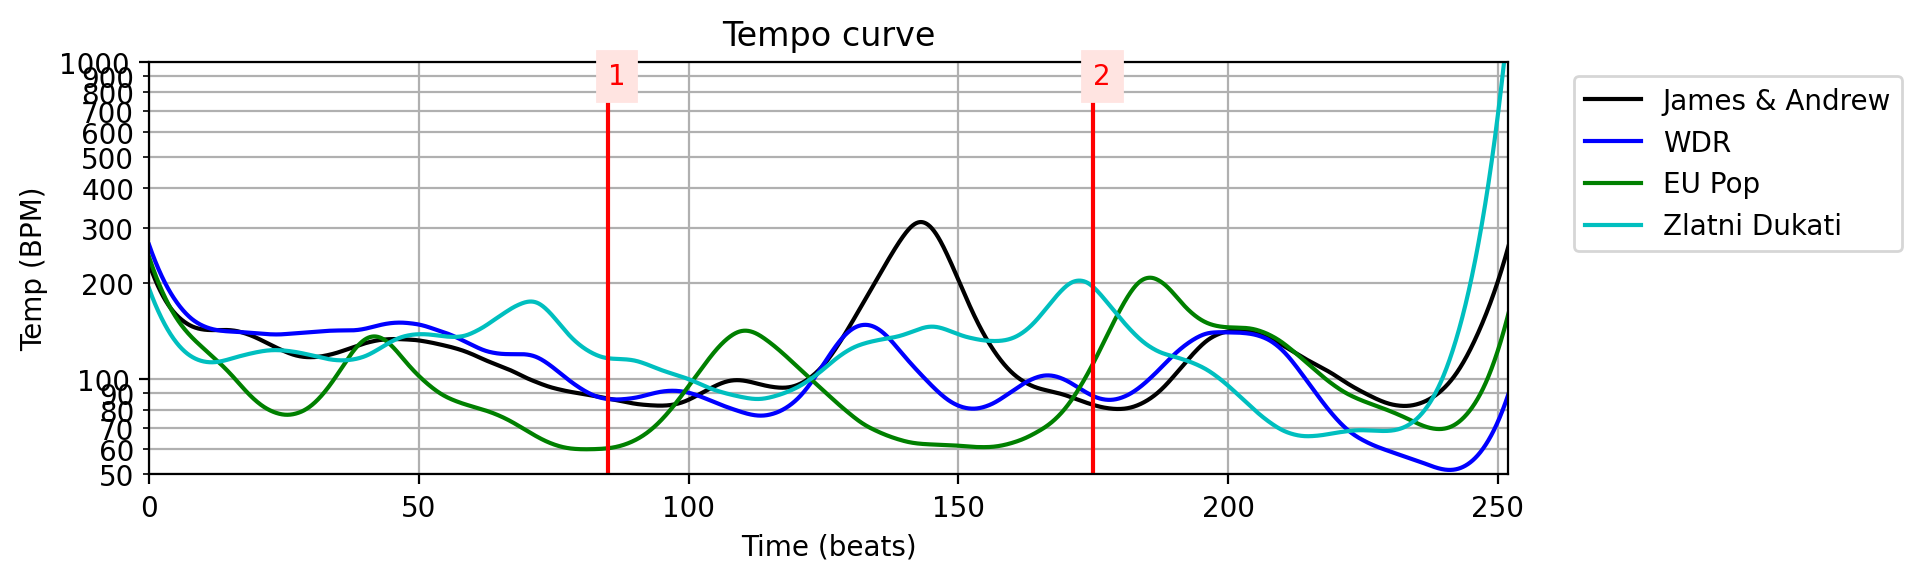

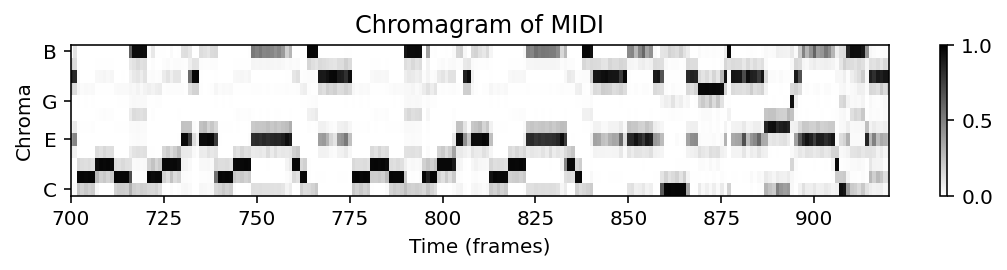

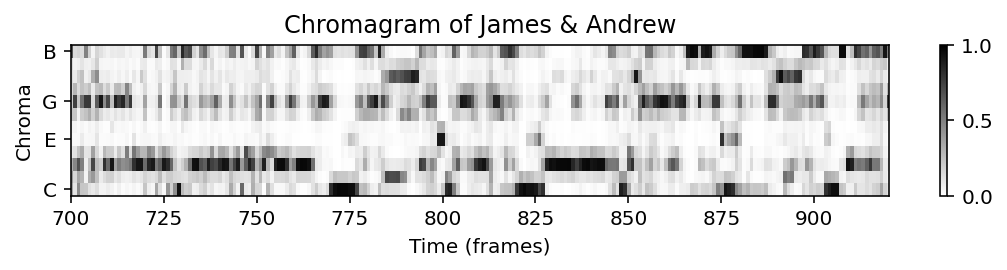

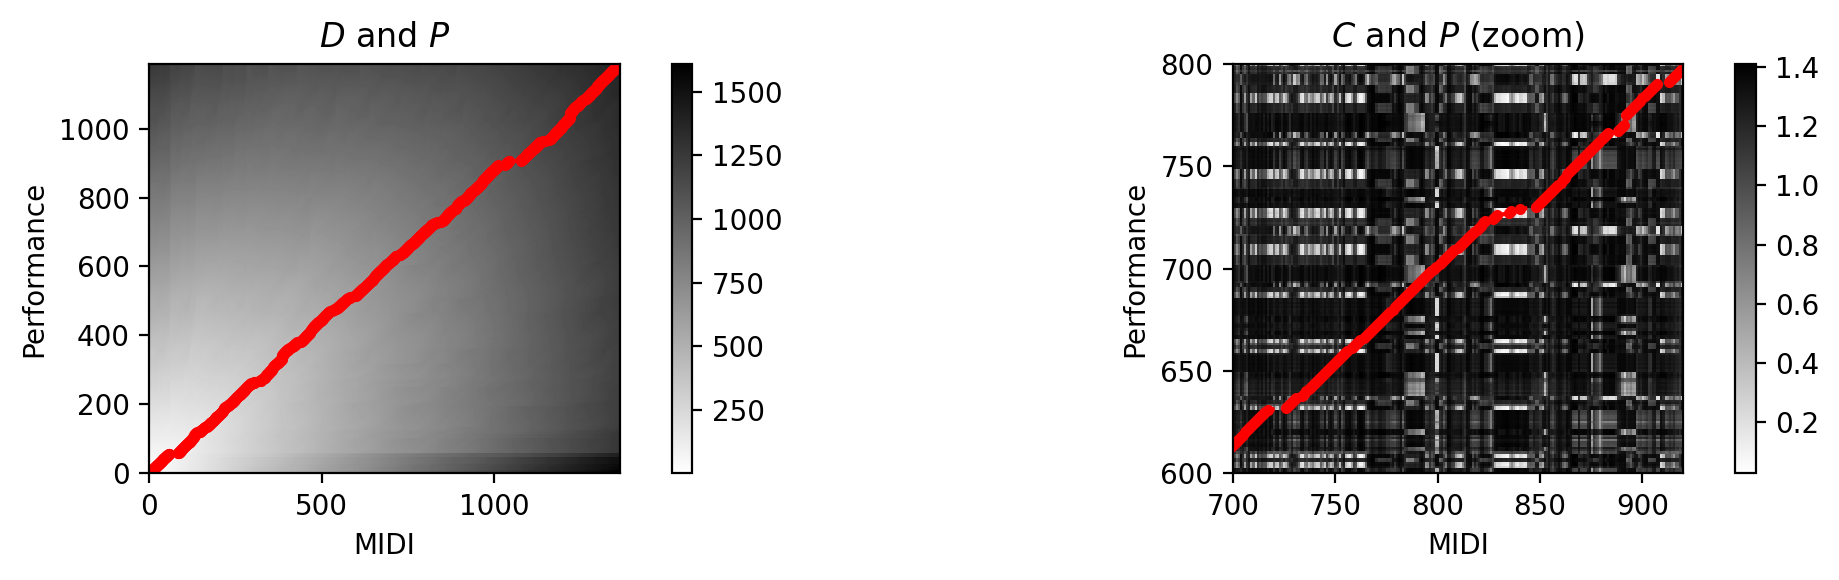

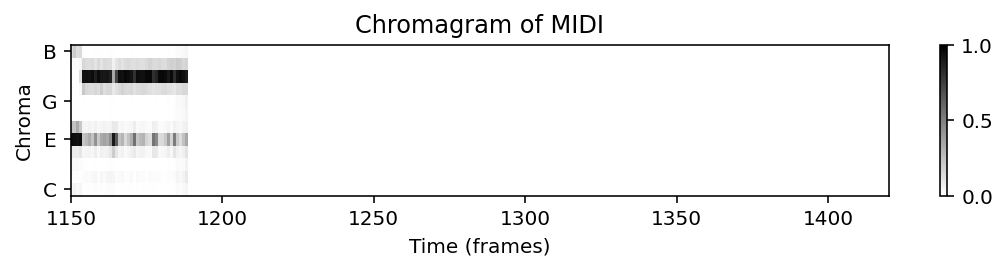

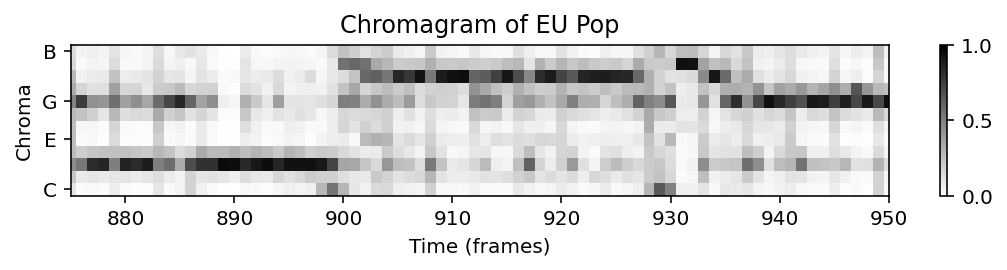

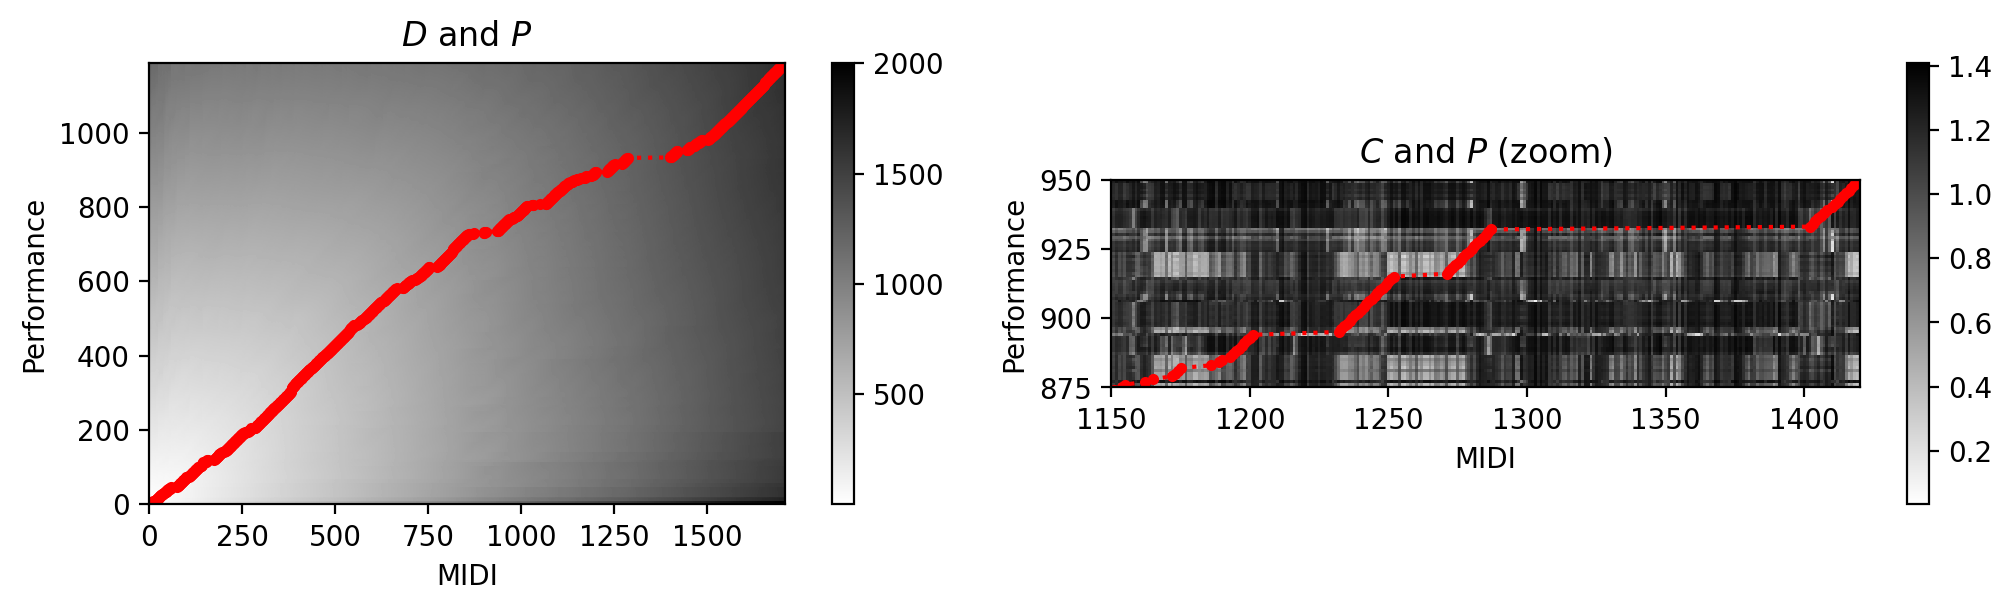

In [4]:
ylim = [50,1000]
measure_pos_beat = [85,175]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['James & Andrew', 'k', 0, os.path.join('sounds', 'James_Ehnes_&_Andrew_Armstrong.wav')]
para_dict[1] = ['WDR', 'b', 0, os.path.join('sounds', 'WDR_Symphony_Orchestra_&_Cristian_Macelaru.wav')]
para_dict[2] = ['EU Pop', 'g', 0, os.path.join('sounds', 'The_European_Pop_Orchestra.wav')]
para_dict[3] = ['Zlatni Dukati', 'c', 0, os.path.join('sounds', 'Zlatni_Dukati.mp3')]

for n in para_dict:
    if n == len(para_dict)-1:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        win_len_beat = 32
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat, ylim = ylim)
    else:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        win_len_beat = 32
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, ylim=ylim)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()

#-----------------------------------------------------------------------------------------------------------#
fn_wav_MIDI = os.path.join('sounds', 'MIDI.wav')
x_MIDI, Fs_MIDI = librosa.load(fn_wav_MIDI)
#score_MIDI = libfmp.c1.csv_to_list(fn_score)
X_MIDI = librosa.feature.chroma_stft(y=x_MIDI, sr=Fs_MIDI, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_MIDI, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title='Chromagram of MIDI', chroma_yticks=[0, 4, 7, 11])
ax = plt.gca()
ax.set_xlim(700,920)

#-----------------------------------------------------------------------------------------------------------#
performer, color, shift, fn_wav = para_dict[0]
x_JA, Fs_JA = librosa.load(fn_wav)
score_JA = libfmp.c1.csv_to_list(fn_score)
X_JA = librosa.feature.chroma_stft(y=x_JA, sr=Fs_JA, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_JA, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title=f'Chromagram of {performer}', chroma_yticks=[0, 4, 7, 11]);
ax = plt.gca()
ax.set_xlim(700,920) 

#-----------------------------------------------------------------------------------------------------------#
# Compute DTW and plot C, D, P
C = libfmp.c3.compute_cost_matrix(X_MIDI, X_JA, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :] 
P = compute_strict_alignment_path(P)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))    
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$D$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
ax[1].set_xlim(700,920)
ax[1].set_ylim(600,800)
plt.tight_layout()

#-----------------------------------------------------------------------------------------------------------#
fn_wav_MIDI = os.path.join('sounds', 'MIDI.wav')
x_MIDI, Fs_MIDI = librosa.load(fn_wav_MIDI)
#score_MIDI = libfmp.c1.csv_to_list(fn_score)
X_MIDI = librosa.feature.chroma_stft(y=x_MIDI, sr=Fs_MIDI, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_MIDI, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title='Chromagram of MIDI', chroma_yticks=[0, 4, 7, 11])
ax = plt.gca()
ax.set_xlim(1150,1420)

#-----------------------------------------------------------------------------------------------------------#
performer, color, shift, fn_wav = para_dict[2]
x_EU, Fs_EU = librosa.load(fn_wav)
score_EU = libfmp.c1.csv_to_list(fn_score)
X_EU = librosa.feature.chroma_stft(y=x_EU, sr=Fs_EU, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_EU, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title=f'Chromagram of {performer}', chroma_yticks=[0, 4, 7, 11]);
ax = plt.gca()
ax.set_xlim(875,950)

#-----------------------------------------------------------------------------------------------------------#
# Compute DTW and plot C, D, P
C = libfmp.c3.compute_cost_matrix(X_MIDI, X_EU, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :] 
P = compute_strict_alignment_path(P)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))    
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$D$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
ax[1].set_xlim(1150,1420)
ax[1].set_ylim(875,950)
plt.tight_layout()

#1 frame = 0.1 seconds
#1 beat ~= 0.5 seconds
# in JA the beats go up in ~120 until 160 converting to frames we get 600 => 800
# in EU we go from ~175 until 190 converting we get 875 => 950

performas mais tranquilas:

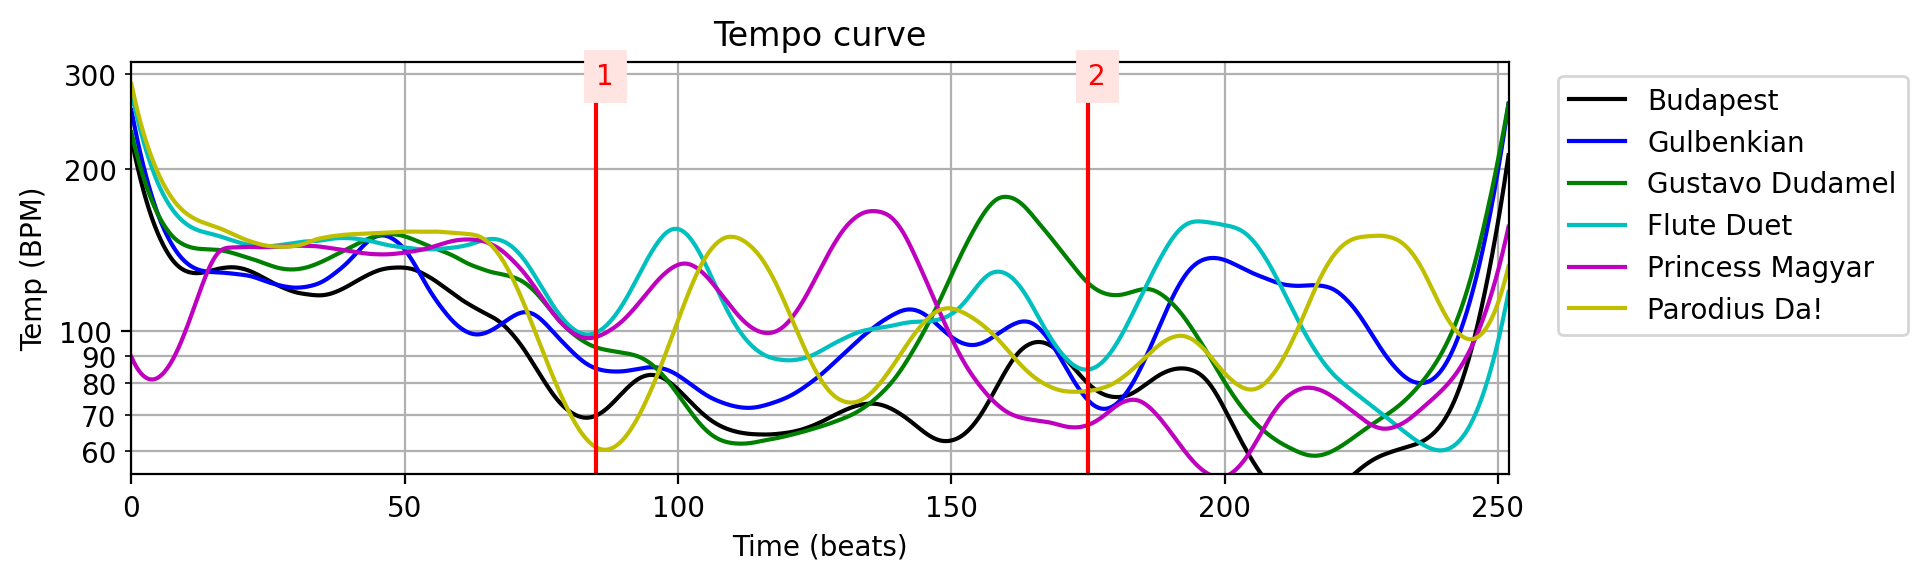

In [5]:
ylim=[50, 400]
measure_pos_beat = [85,175]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['Budapest', 'k', 0, os.path.join('sounds', 'Hungarian_Symphony_Orchestra_Budapest.wav')]
para_dict[1] = ['Gulbenkian', 'b', 0, os.path.join('sounds', 'Gulbenkian_Orquestra.wav')]
para_dict[2] = ['Gustavo Dudamel', 'g', 0, os.path.join('sounds', 'Gustavo_Dudamel.wav')]
para_dict[3] = ['Flute Duet', 'c', 0, os.path.join('sounds', 'Flute_Duet.wav')]
para_dict[4] = ['Princess Magyar', 'm', 0, os.path.join('sounds', 'Princess_Magyar.mp3')]
para_dict[5] = ['Parodius Da!', 'y', 0, os.path.join('sounds', 'Parodius_Da!.mp3')]

for n in para_dict:
    if n == len(para_dict)-1:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        win_len_beat = 32
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        #plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, ylim=ylim)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat)
    else:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        win_len_beat = 32
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, ylim=ylim)
        #plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()


# Casos peculiares:

In 1948, “Concert Magic” was filmed in Hollywood making it the first-ever concert filmed for movie audiences. Yehudi Menuhin and other internationally renowned interpreters played classical and romantic works and created a worldwide success for the director Paul Gordon. 

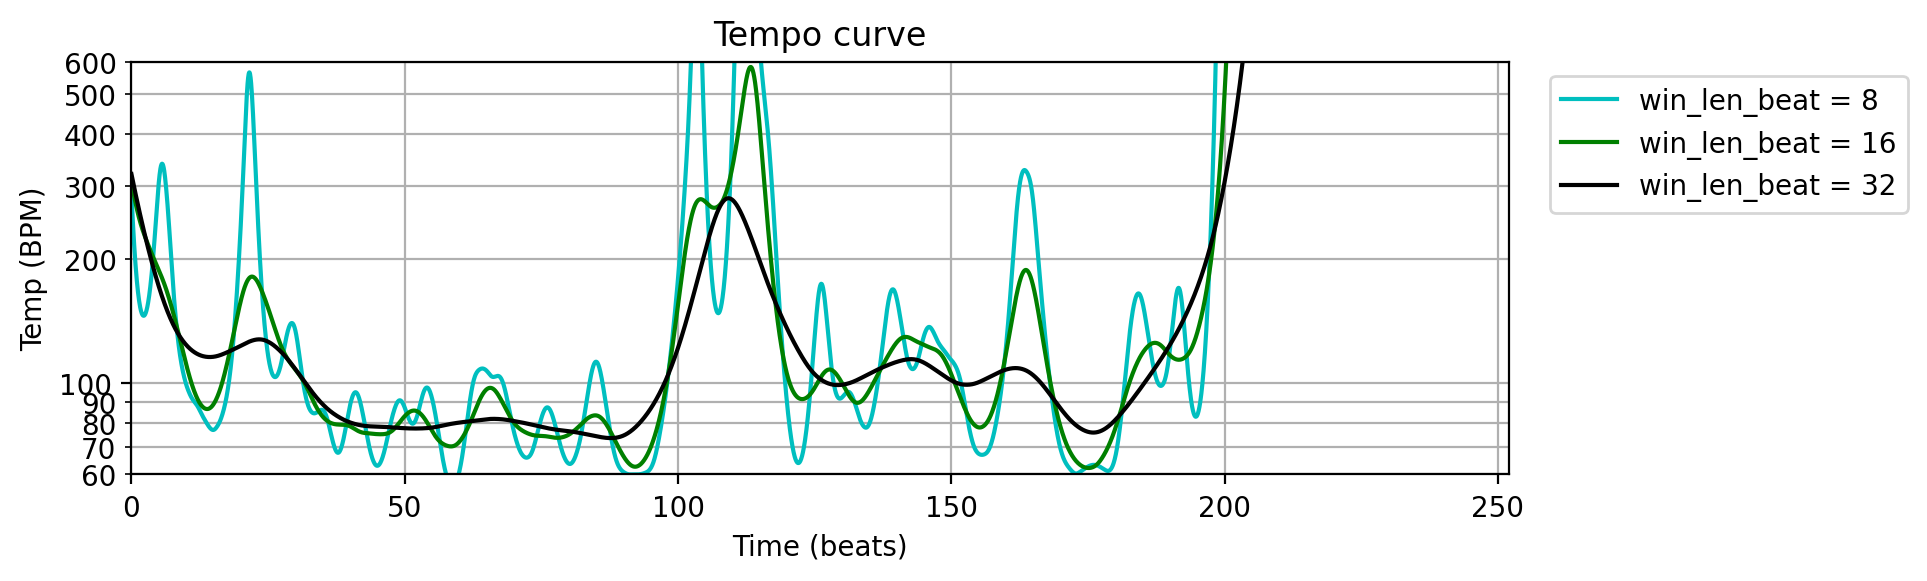

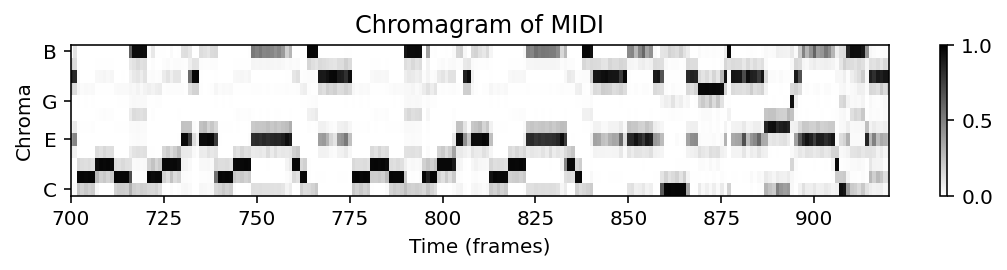

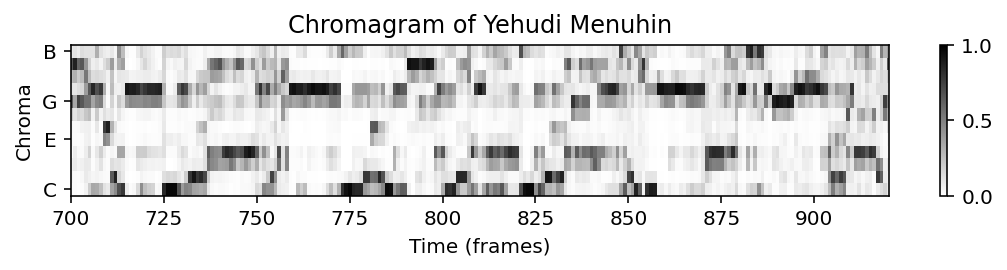

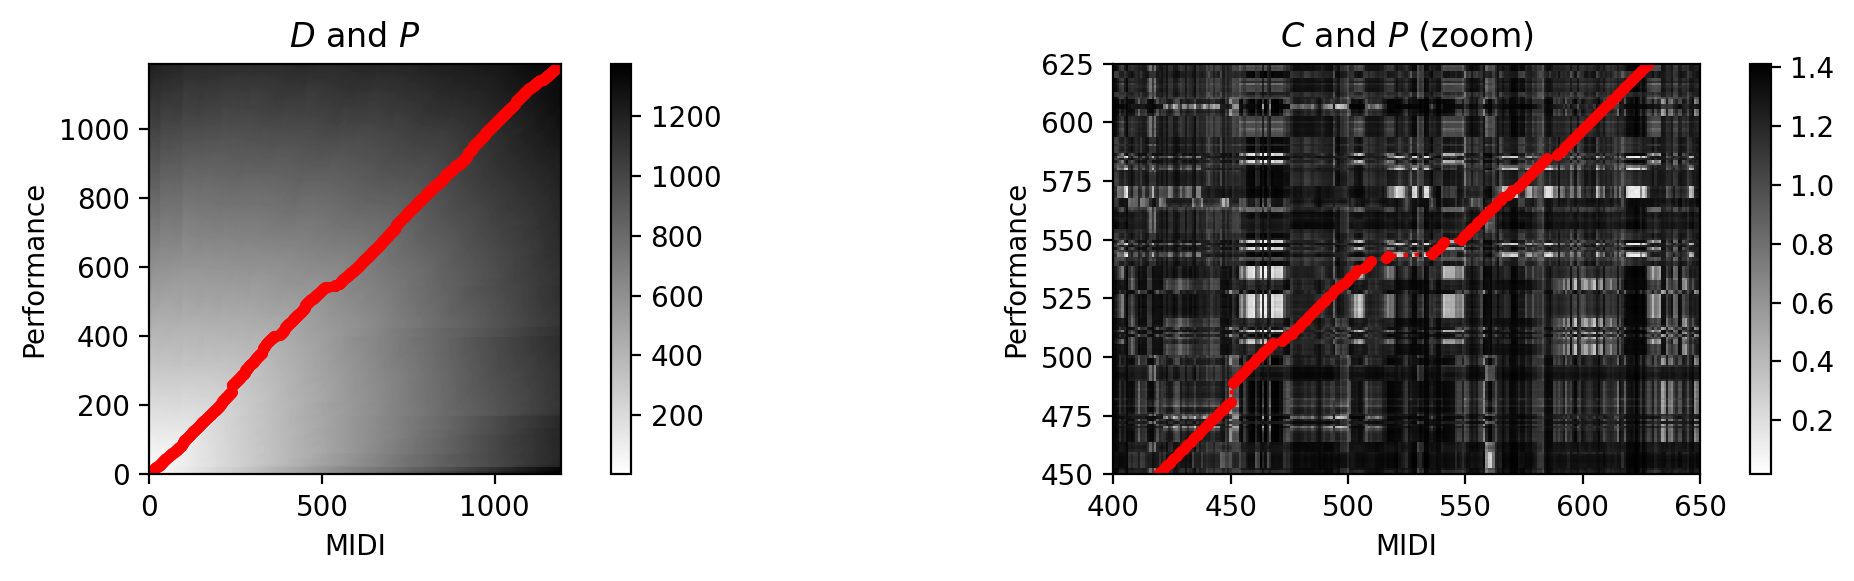

In [6]:
ylim=[60, 600]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['Yehudi Menuhin', 'c', 0, os.path.join('sounds', 'Yehudi_Menuhin.wav')]

win_len_list = [8, 16, 32]
colors = ['c','g','k']

for win_len_beat, colo in zip(win_len_list, colors):
    for n in para_dict:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=colo, label=f'win_len_beat = {win_len_beat}', logscale=True, ylim=ylim)
        
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
#1 frame = 0.1 seconds
#1 beat ~= 0.5 seconds
# anomalidade entre 90,125 beats => 450,625
#-----------------------------------------------------------------------------------------------------------#
fn_wav_MIDI = os.path.join('sounds', 'MIDI.wav')
x_MIDI, Fs_MIDI = librosa.load(fn_wav_MIDI)
#score_MIDI = libfmp.c1.csv_to_list(fn_score)
X_MIDI = librosa.feature.chroma_stft(y=x_MIDI, sr=Fs_MIDI, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_MIDI, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title='Chromagram of MIDI', chroma_yticks=[0, 4, 7, 11])
ax = plt.gca()
ax.set_xlim(700,920)

#-----------------------------------------------------------------------------------------------------------#
performer, color, shift, fn_wav = para_dict[0]
x_YM, Fs_YM = librosa.load(fn_wav)
score_YM = libfmp.c1.csv_to_list(fn_score)
X_YM = librosa.feature.chroma_stft(y=x_YM, sr=Fs_YM, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_YM, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title=f'Chromagram of {performer}', chroma_yticks=[0, 4, 7, 11]);
ax = plt.gca()
ax.set_xlim(700,920) 

#-----------------------------------------------------------------------------------------------------------#
# Compute DTW and plot C, D, P
C = libfmp.c3.compute_cost_matrix(X_MIDI, X_YM, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :] 
P = compute_strict_alignment_path(P)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))    
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$D$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
ax[1].set_xlim(400,650)
ax[1].set_ylim(450,625)
plt.tight_layout()

# Jazz

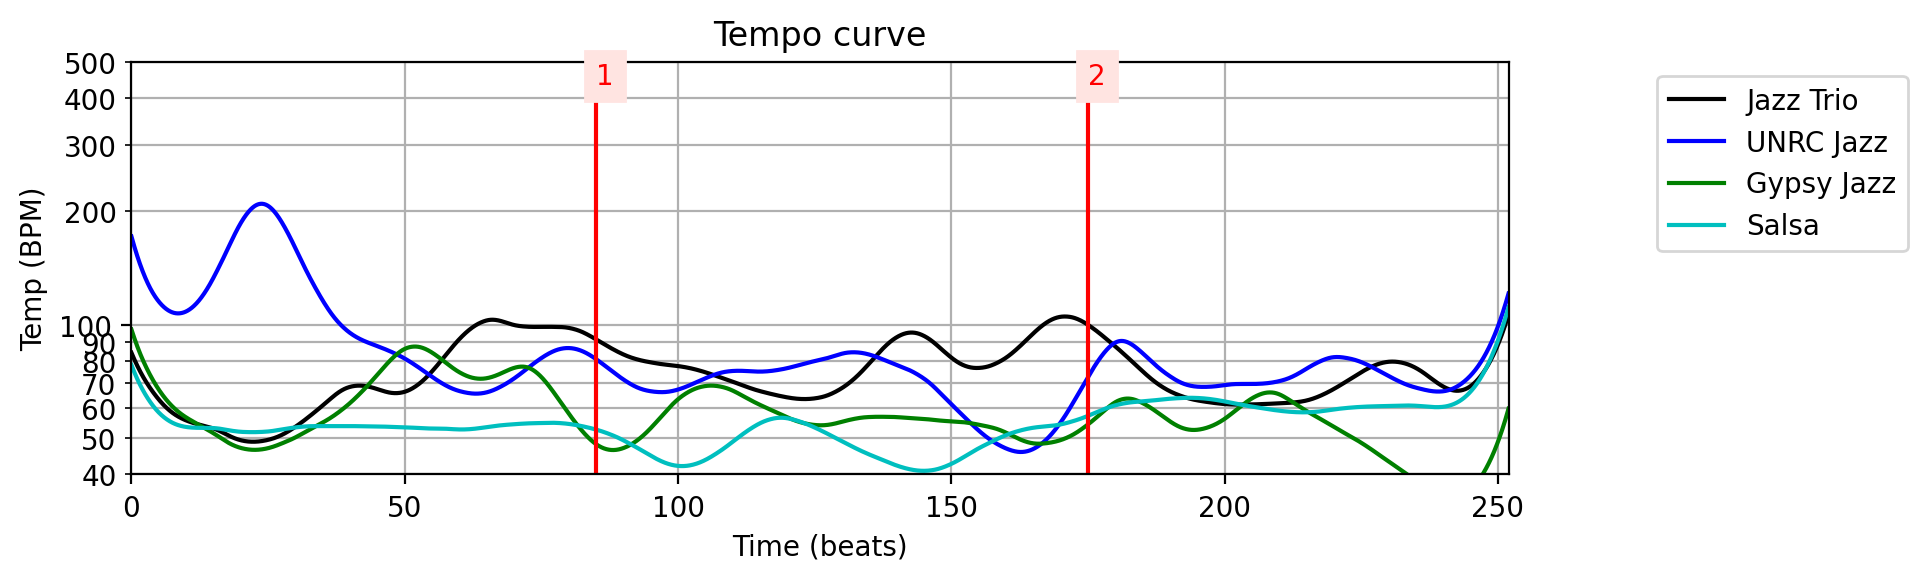

In [7]:
ylim=[40, 500]
measure_pos_beat = [85,175]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['Jazz Trio', 'k', 0, os.path.join('sounds', 'EU_Jazz_Trio.wav')]
para_dict[1] = ['UNRC Jazz', 'b', 0, os.path.join('sounds', 'UNRC_Jazz.mp3')]
para_dict[2] = ['Gypsy Jazz', 'g', 0, os.path.join('sounds', 'Gypsy_Jazz.mp3')]
para_dict[3] = ['Salsa', 'c', 0, os.path.join('sounds', 'Salsa.wav')]
for n in para_dict:
    if n == len(para_dict)-1:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        win_len_beat = 32
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat, ylim=ylim)
    else:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        win_len_beat = 32
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, ylim=ylim)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()

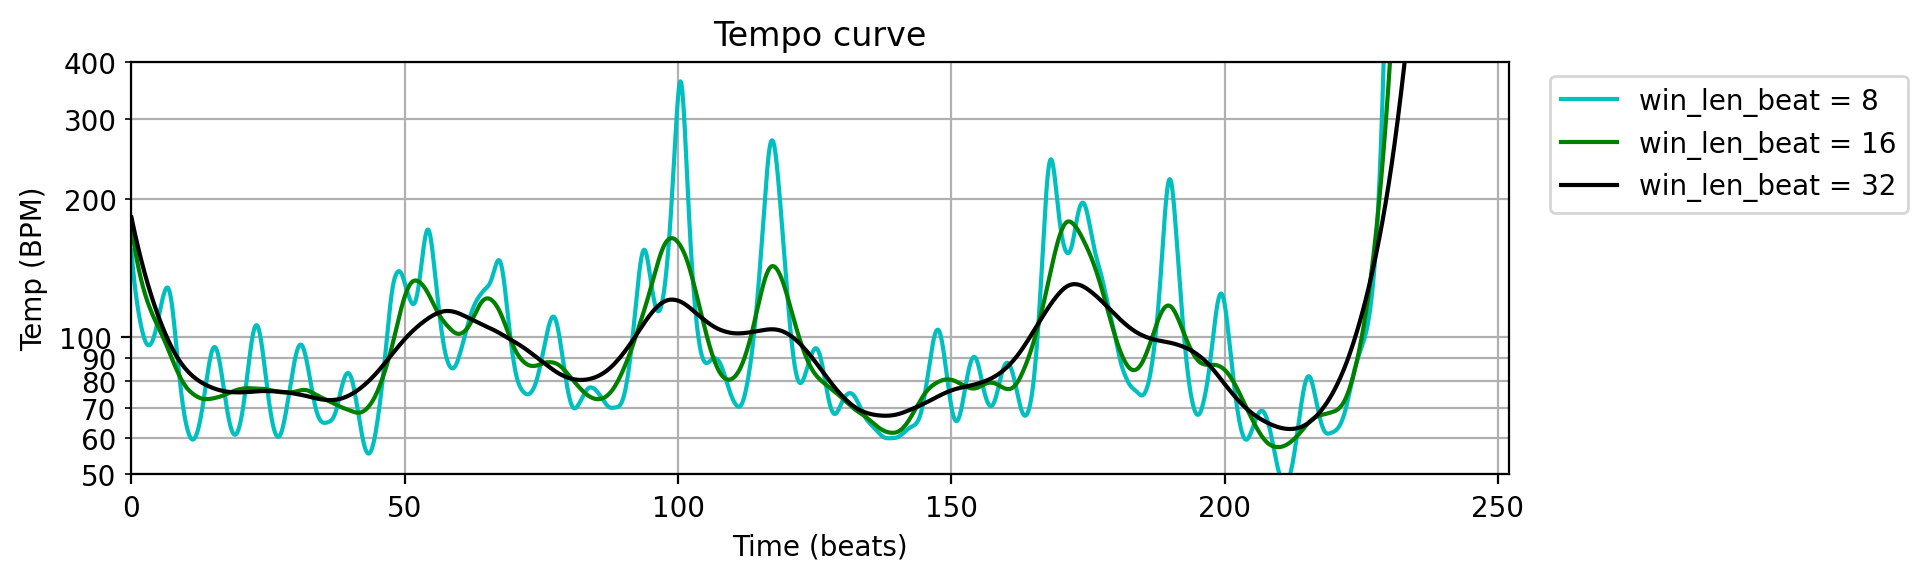

In [8]:
ylim=[50, 400]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['Chihiro Yamanaka', 'c', 0, os.path.join('sounds', 'Chihiro_Yamanaka.mp3')]


win_len_list = [8, 16, 32]
colors = ['c','g','k']

for win_len_beat, colo in zip(win_len_list, colors):
    for n in para_dict:
        performer, color, shift, fn_wav = para_dict[n]
        x, Fs = librosa.load(fn_wav)
        f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
        plot_tempo_curve(f_tempo, t_beat, ax=ax, color=colo, label=f'win_len_beat = {win_len_beat}', logscale=True, ylim=ylim) 
        #plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()

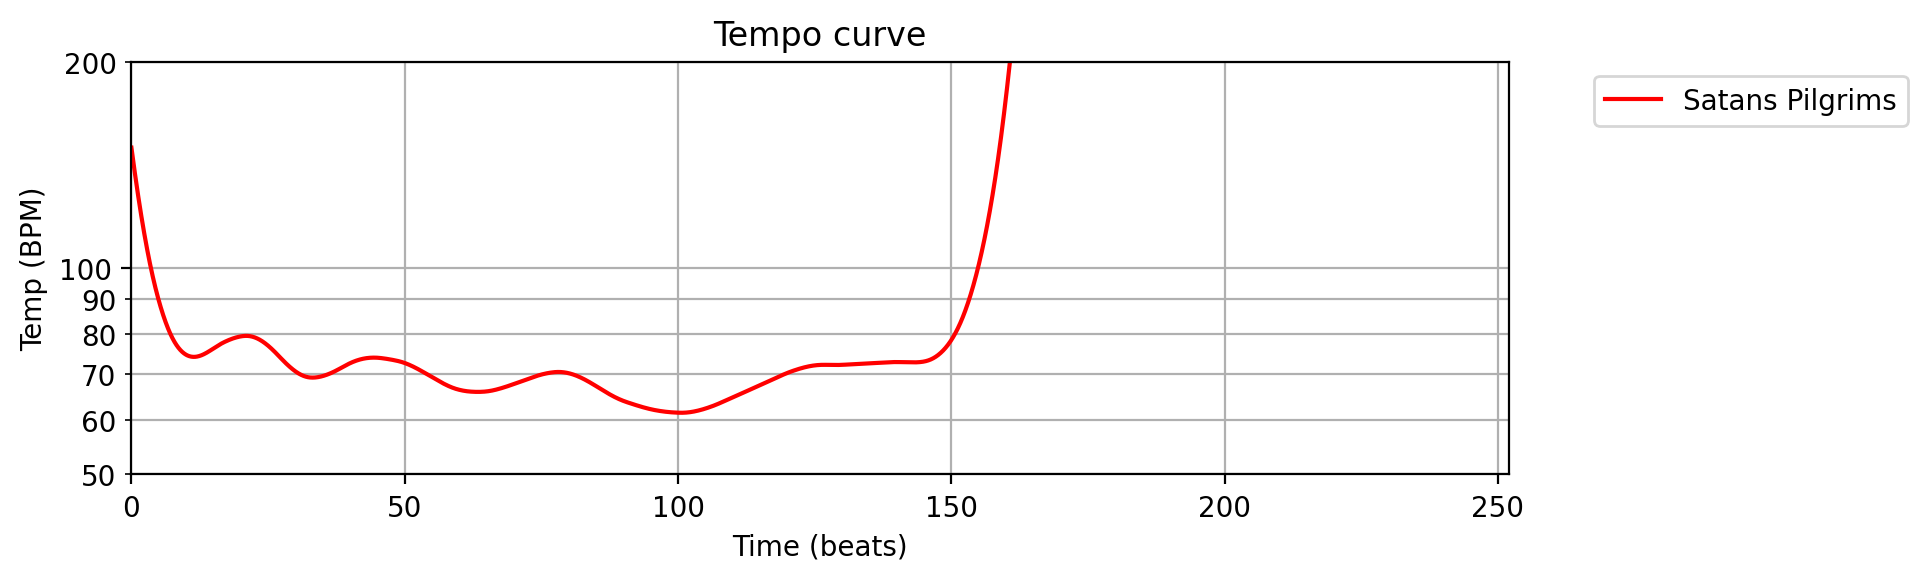

In [9]:
ylim=[50, 200]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['Satans Pilgrims', 'r', 0, os.path.join('sounds', 'Satans_Pilgrims.mp3')]
for n in para_dict:
    performer, color, shift, fn_wav = para_dict[n]
    x, Fs = librosa.load(fn_wav)
    win_len_beat = 32
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
    plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, ylim=ylim)
    #plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()

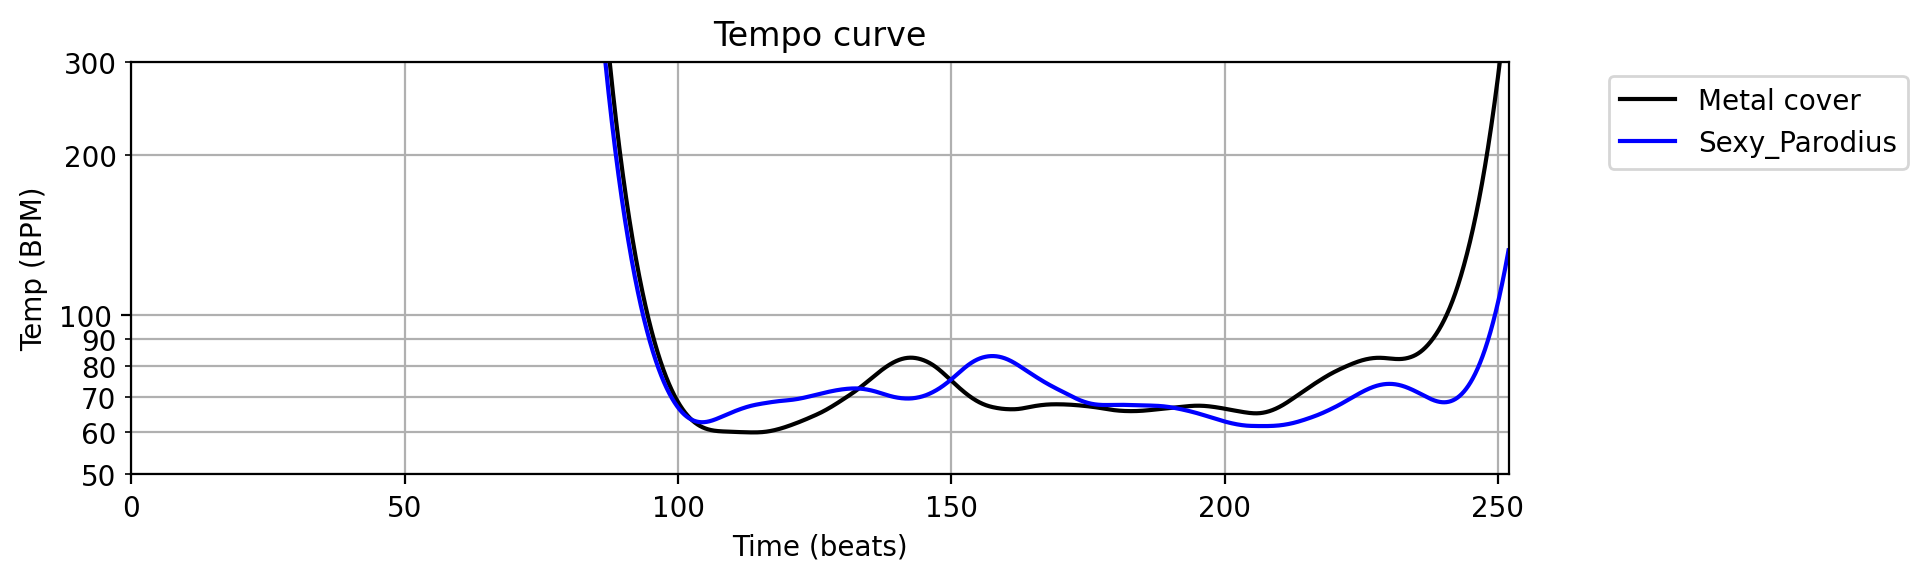

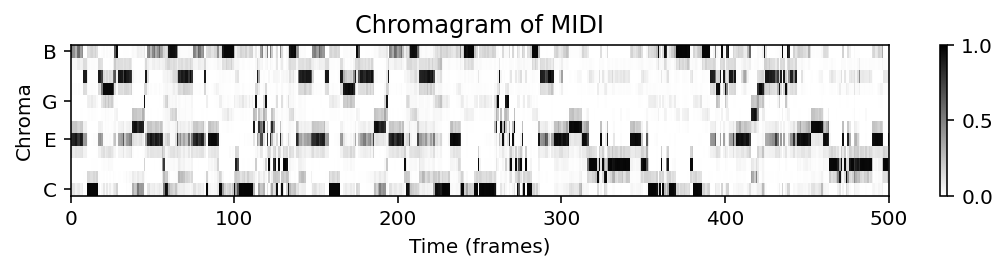

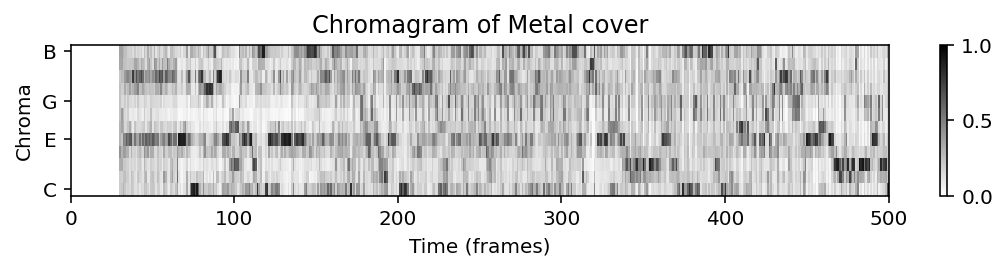

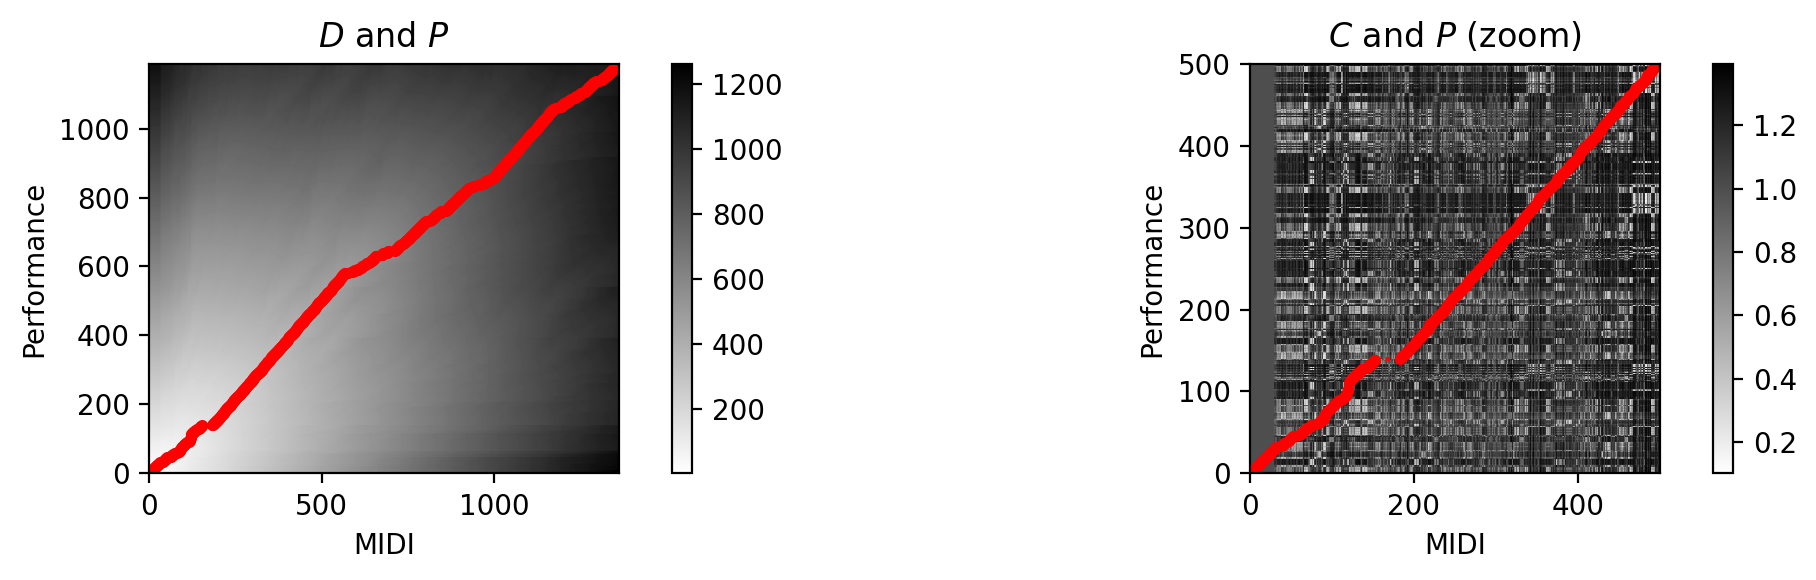

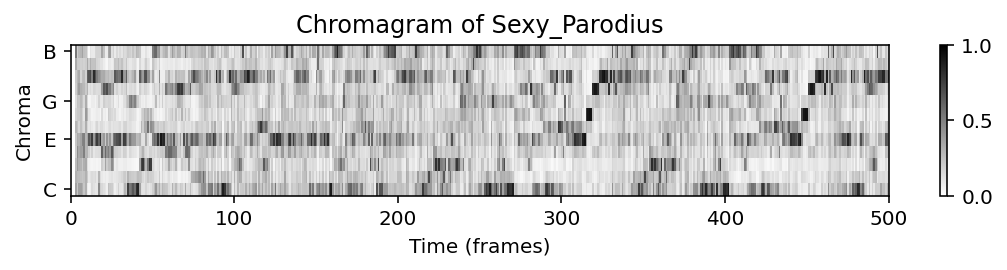

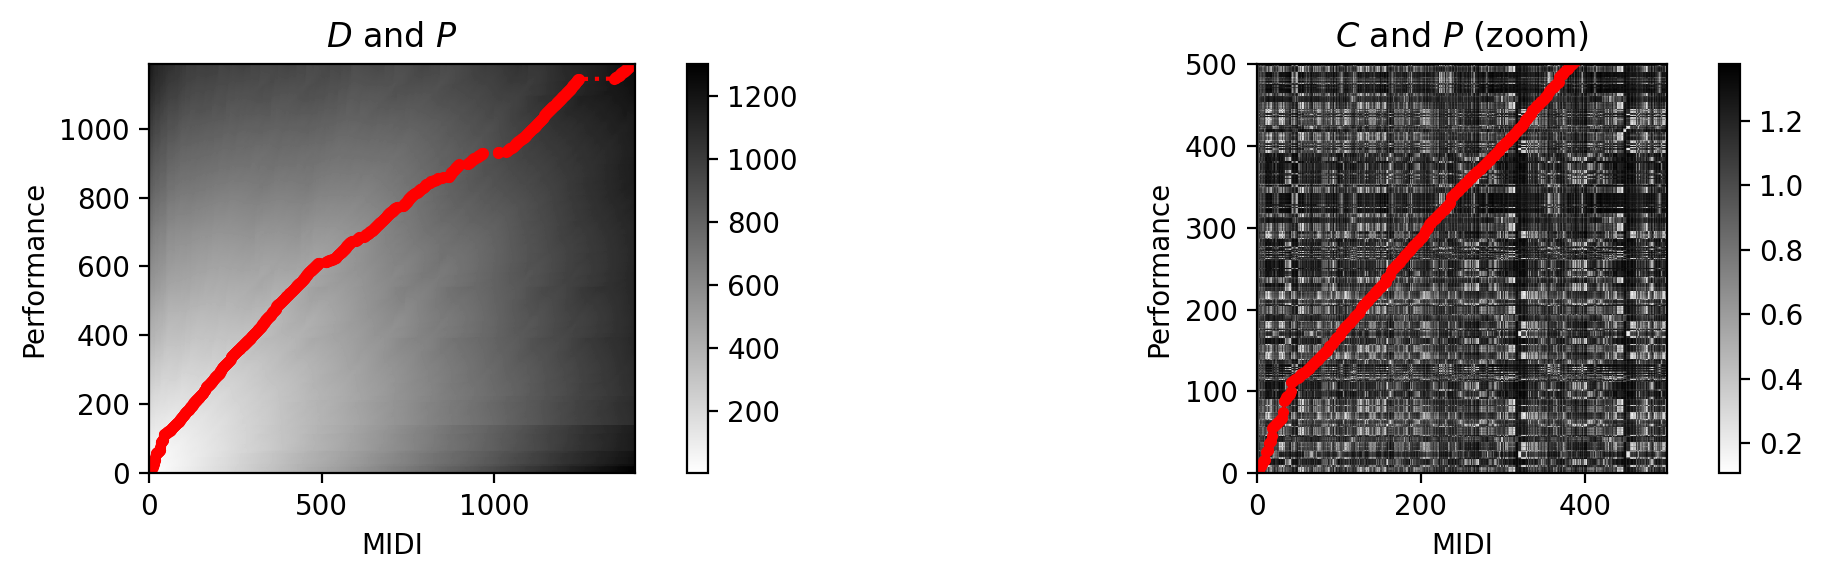

In [10]:
ylim = [50,300]
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Set the title of the plot
plt.title('Dependency on performer')

# Define a dictionary 'para_dict' containing performer information
para_dict = {}
para_dict[0] = ['Metal cover', 'k', 0, os.path.join('sounds', 'Metal_cover.mp3')]
para_dict[1] = ['Sexy_Parodius', 'b', 0, os.path.join('sounds', 'Sexy_Parodius.mp3')]
for n in para_dict:
    performer, color, shift, fn_wav = para_dict[n]
    x, Fs = librosa.load(fn_wav)
    win_len_beat = 32
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
    plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, ylim=ylim)
    #plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer, logscale=True, measure_pos=measure_pos_beat)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()

#-----------------------------------------------------------------------------------------------------------#
#1 frame = 0.1 seconds
#1 beat ~= 0.5 seconds
# anomalidade entre 0,100 beats => 0,500
#-----------------------------------------------------------------------------------------------------------#
fn_wav_MIDI = os.path.join('sounds', 'MIDI.wav')
x_MIDI, Fs_MIDI = librosa.load(fn_wav_MIDI)
#score_MIDI = libfmp.c1.csv_to_list(fn_score)
X_MIDI = librosa.feature.chroma_stft(y=x_MIDI, sr=Fs_MIDI, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_MIDI, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title='Chromagram of MIDI', chroma_yticks=[0, 4, 7, 11])
ax = plt.gca()
ax.set_xlim(0,500)
#-----------------------------------------------------------------------------------------------------------#
performer, color, shift, fn_wav = para_dict[0]
x_ME, Fs_ME = librosa.load(fn_wav)
score_ME = libfmp.c1.csv_to_list(fn_score)
X_ME = librosa.feature.chroma_stft(y=x_ME, sr=Fs_ME, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_ME, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title=f'Chromagram of {performer}', chroma_yticks=[0, 4, 7, 11]);
ax = plt.gca()
ax.set_xlim(0,500) 
#-----------------------------------------------------------------------------------------------------------#
# Compute DTW and plot C, D, P
C = libfmp.c3.compute_cost_matrix(X_MIDI, X_ME, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :] 
P = compute_strict_alignment_path(P)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))    
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$D$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,500)
plt.tight_layout()
#-----------------------------------------------------------------------------------------------------------#
performer, color, shift, fn_wav = para_dict[1]
x_SP, Fs_SP = librosa.load(fn_wav)
score_SP = libfmp.c1.csv_to_list(fn_score)
X_SP = librosa.feature.chroma_stft(y=x_SP, sr=Fs_SP, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X_SP, figsize=figsize, xlabel='Time (frames)', clim=[0, 1], title=f'Chromagram of {performer}', chroma_yticks=[0, 4, 7, 11]);
ax = plt.gca()
ax.set_xlim(0,500) 
#-----------------------------------------------------------------------------------------------------------#
# Compute DTW and plot C, D, P
C = libfmp.c3.compute_cost_matrix(X_MIDI, X_SP, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :] 
P = compute_strict_alignment_path(P)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))    
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$D$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance', xlabel='MIDI',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,500)
plt.tight_layout()

# Tentando arrumar o problema das musicas acima: